In [1]:
# Importar as bibliotecas necessárias: destaque para pytorch

import numpy as np
import PIL.Image

import torch, torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
# from grayscale_alexnet import AlexNet
import time

from matplotlib import pyplot as plt

import os

In [2]:
image_size = 100

# Transformando as imagens: para modelos mais robustos tem que caprichar no data augmentation!
# Nesse caso não fizemos nada além do redimensionamento da imagem, mas é sempre bom fazer rotações,
# espelhamentos, crop randomicos pra garantir 
transformacoes_de_imagens = { 
    'treino': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'validacao': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'teste': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ])
}

In [3]:
# Carregar as imagens
# Determinar as pastas de treino, validação e teste

dataset = r'../data/'

pasta_treino = os.path.join(dataset, 'treino')
pasta_validacao = os.path.join(dataset, 'validacao')
pasta_teste = os.path.join(dataset, 'teste')

In [4]:
# Tamanho do batch de treinamento
bs = 8

# Determinando o número de classes
numero_de_classes = len(os.listdir(pasta_validacao)) 
numero_de_classes 

2

In [35]:
# Carregar as imagens usando o datasets do torchvision
data = {
    'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes_de_imagens['treino']),
    'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes_de_imagens['validacao']),
    'teste': datasets.ImageFolder(root=pasta_teste, transform=transformacoes_de_imagens['teste'])
}

In [36]:
data

{'treino': Dataset ImageFolder
     Number of datapoints: 144
     Root location: ../data/treino
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 'validacao': Dataset ImageFolder
     Number of datapoints: 36
     Root location: ../data/validacao
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 'teste': Dataset ImageFolder
     Number of datapoints: 20
     Root location: ../data/teste
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            )}

In [37]:
# Mapear os índices com os nomes das classes (entregue e devolvido)
indice_para_classe = {v: k for k, v in data['treino'].class_to_idx.items()}
print(indice_para_classe)

# Quantidade de imagens para serem utilizados para calcular erro médio e acurácia
num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

# Cria os DataLoaders para treino e validação
data_loader_treino = DataLoader(data['treino'], batch_size=bs, shuffle=True)
data_loader_validacao = DataLoader(data['validacao'], batch_size=bs, shuffle=True)

data_loader_teste = DataLoader(data['teste'], batch_size=3, shuffle=True)

{0: 'high_temp', 1: 'low_temp'}


In [38]:
data_loader_teste

In [39]:
listimg = []
for i, (entradas, labels) in enumerate(data_loader_teste):
    print(entradas)
    listimg.append(entradas)
    break

tensor([[[[0.5529, 0.5333, 0.5020,  ..., 0.4863, 0.5569, 0.5725],
          [0.4824, 0.4784, 0.4941,  ..., 0.5882, 0.5765, 0.5020],
          [0.5216, 0.5137, 0.5020,  ..., 0.5333, 0.5647, 0.5922],
          ...,
          [0.5294, 0.6471, 0.6902,  ..., 0.4745, 0.5059, 0.5569],
          [0.5647, 0.5804, 0.5647,  ..., 0.4745, 0.4980, 0.5412],
          [0.5529, 0.5569, 0.5333,  ..., 0.4902, 0.5137, 0.4980]],

         [[0.5529, 0.5333, 0.5020,  ..., 0.4863, 0.5569, 0.5725],
          [0.4824, 0.4784, 0.4941,  ..., 0.5882, 0.5765, 0.5020],
          [0.5216, 0.5137, 0.5020,  ..., 0.5333, 0.5647, 0.5922],
          ...,
          [0.5294, 0.6471, 0.6902,  ..., 0.4745, 0.5059, 0.5569],
          [0.5647, 0.5804, 0.5647,  ..., 0.4745, 0.4980, 0.5412],
          [0.5529, 0.5569, 0.5333,  ..., 0.4902, 0.5137, 0.4980]],

         [[0.5529, 0.5333, 0.5020,  ..., 0.4863, 0.5569, 0.5725],
          [0.4824, 0.4784, 0.4941,  ..., 0.5882, 0.5765, 0.5020],
          [0.5216, 0.5137, 0.5020,  ..., 0

In [40]:
listimg[0].shape

torch.Size([3, 3, 100, 100])

In [33]:
listimg[0][0].shape

torch.Size([3, 100, 100])

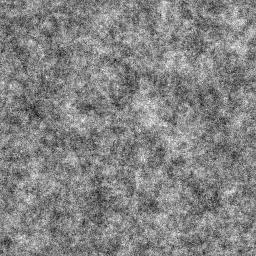

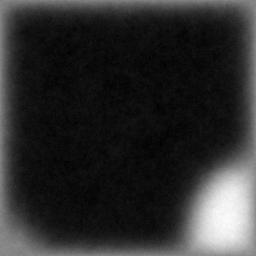

In [11]:
from IPython.display import Image 

# Mostrar algumas imagens
for classe in indice_para_classe.values():
    pasta_classe = os.path.join(pasta_treino, classe)
    arquivo_imagem = os.listdir(pasta_classe)[1]
    img = Image(filename=os.path.join(pasta_classe, arquivo_imagem))
    display(img)

In [13]:
alexnet = models.alexnet(pretrained=True)
# alexnet = AlexNet(num_classes=2)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
# Congelar os parametros da rede pré-treinada
for param in alexnet.parameters():
    param.requires_grad = False

In [15]:
# Mudar a última camada para alterar o número de classes
# alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
alexnet.classifier[6] = nn.Linear(4096, numero_de_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
# Definição de algoritmo de otimização de gradiente descendente e função de erro
funcao_erro = nn.NLLLoss() # negative log likelihood loss
otimizador = optim.Adam(alexnet.parameters()) # otimizador de passos para o SGD
otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [17]:
def treinar_e_validar(modelo, metrica_erro, otimizador_sgd, epocas, device):
    # epocas=25
    '''
    Função para treinamento e validação
    Parâmetros
        :param modelo: modelo para treinar e validar
        :param metrica_erro: critério de erro para minização
        :param otimizador_sgd: otimizador para calcular os gradientes
        :param epocas: número de épocas (default=25)
  
    Retorna
        melhor_modelo: modelo treinado com a melhor acurácia na validação
        historico: (dicionário): histórico com erro no treinamento, erro na validação e acurácia
    '''
    
    # inicializando historico, a melhor acuracia de validação e o melhor modelo de acordo com a validação
    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None

    # Cada época perpassa todas as imagens do treino e calcula erros de treino e validação
    # para aprendizado da rede neural
    for epoca in range(epocas):
        inicio_epoca = time.time()
        print("\n\nÉpoca: {}/{}".format(epoca+1, epocas))
        
        # Mudar o modelo para modo treino: vai atualizar os parametros da rede neural
        modelo.train()
        
        # Erro e acurácia de treino nessa época
        erro_treino = 0.0
        acuracia_treino = 0.0
        
        # Erro e acurácia de validação nessa época
        erro_validacao = 0.0
        acuracia_validacao = 0.0
        
        # Itera a cada lote de imagem. As entradas são os tensores do lote (batch)
        # e o label são as classificações de cada imagem do lote: 
        # chocolate, guaraná ou coca cola (0, 1 e 2)
        for i, (entradas, labels) in enumerate(data_loader_treino):

            # joga pra GPU ou CPU, dependendo do seu hardware
            entradas = entradas.cpu()
            labels = labels.cpu()
            modelo.cpu()
            
            # Limpar os gradientes: zerar os gradientes
            otimizador_sgd.zero_grad()
            
            # Forward pass - calcular saídas a partir das entradas utilizando o modelo
            saidas = modelo(entradas)
            
            # Calcular erro das saidas que foram preditas no forward pass
            # comparando com as classificacoes reais (predito vs real)
            erro = metrica_erro(saidas, labels)
            
            # Realizar backpropagation do erro para treinar os coeficientes da rede
            erro.backward()
            
            # Atualizar os parâmetros do otimizador (no nosso caso, Adam Optimizer)
            otimizador_sgd.step()
            
            # Calcular o erro total para esse lote (batch) e soma o erro no treino
            erro_treino += erro.item() * entradas.size(0)
            
            # Cálculo da acurácia
            # Pra calcular a acurácia temos que buscar as classes preditas para cada imagem no lote
            
            # Cada tensor é uma imagem do lote com três posições: probabilidades de cada classe
            # torch.max vai retornar o valor da maior probabilidade, bem como a posição no tensor (tupla de saída)
            # A posição, portanto, vai indicar a classe com maior probabilidade (0,1 ou 2)
            # 1o busca o valor máximo de cada tensor de cada imagem, que vai dar 
            valores_maximos, indices_dos_valores_maximos = torch.max(saidas.data, 1)
            predicoes_corretas = indices_dos_valores_maximos.eq(labels.data.view_as(indices_dos_valores_maximos))
            
            # Converter os acertos para float e calcular a acurácia média
            acuracia = torch.mean(predicoes_corretas.type(torch.FloatTensor))
            
            # Calcular a acurácia total de treino do lote todo e adicionar a em train_acc
            acuracia_treino += acuracia.item() * entradas.size(0)
            
            print("Treino - Lote número {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(i, erro.item(), acuracia.item()))

            
        # Validação - não é necessário rastrear os gradientes, pois o modelo não vai ser treinado com a validação
        with torch.no_grad():

            # Mudando de treino para validação
            modelo.eval()

            # Iteração de validação
            for j, (entradas, labels) in enumerate(data_loader_validacao):
                entradas = entradas.cpu()
                labels = labels.cpu()
                modelo.cpu()

                # Forward pass de validação
                saidas = modelo(entradas)

                # Calcular erro de validação
                erro = metrica_erro(saidas, labels)

                # Calcular erro de validação e adicionar a valid_loss
                erro_validacao += erro.item() * entradas.size(0)

                # Calcular a acurácia de validação
                valores_maximos, indices_dos_valores_maximos = torch.max(saidas.data, 1)
                predicoes_corretas = indices_dos_valores_maximos.eq(labels.data.view_as(indices_dos_valores_maximos))

                # Converter os acertos para float e calcular a acurácia média
                acuracia = torch.mean(predicoes_corretas.type(torch.FloatTensor))

                # Calcular a acurácia total de validação do lote todo e adicionar a em train_acc
                acuracia_validacao += acuracia.item() * entradas.size(0)

                print("Validação - Lote número: {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(j, erro.item(), acuracia.item()))
            
        # Calcular a média de erro e acurácia no treino
        erro_medio_treino = erro_treino/num_imagens_treino
        acuracia_media_treino = acuracia_treino/num_imagens_treino

        # Calcular a média de erro e acurácia na validação
        erro_medio_validacao = erro_validacao/num_imagens_validacao
        acuracia_media_validacao = acuracia_validacao/num_imagens_validacao

        # Incluir no histórico os erros e acurácias méidas
        historico.append([erro_medio_treino, erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])
                
        fim_epoca = time.time()
    
        print("Época : {:03d}, Treino: Erro: {:.4f}, Acurácia: {:.4f}%, \n\t\tValidação : Erro : {:.4f}, Acurácia: {:.4f}%, Tempo: {:.4f}s".format(epoca+1, erro_medio_treino, acuracia_media_treino*100, erro_medio_validacao, acuracia_media_validacao*100, fim_epoca-inicio_epoca))
        
        # Testa se a acurácia na validação desse modelo nessa época é a melhor
        # Se for a melhor, salva no melhor modelo e na melhor acurácia
        if acuracia_media_validacao > melhor_acuracia:
            melhor_acuracia = acuracia_media_validacao
            torch.save(modelo, './modelos/melhor_modelo.pt')
            melhor_modelo = modelo
            
    return melhor_modelo, historico

In [18]:
# Se você for rico e tiver uma RTX 3080 (que sonho!!)
# Mas se não for, sem problemas, sua CPU provavelmente vai dar conta do recado!
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Imprime se vai ser CPU ou alguma GPU
print(f'{device}\n')

# Define o número de épocas
numero_de_epocas = 10

# treina o modelo! Finalmente!!
modelo_treinado, historico = treinar_e_validar(alexnet, funcao_erro, otimizador, numero_de_epocas, device)

cpu



Época: 1/10
Treino - Lote número 000, Erro: 0.7857, Acurácia: 0.3750
Treino - Lote número 001, Erro: 0.2691, Acurácia: 1.0000
Treino - Lote número 002, Erro: 0.0869, Acurácia: 1.0000
Treino - Lote número 003, Erro: 0.0489, Acurácia: 1.0000
Treino - Lote número 004, Erro: 0.0185, Acurácia: 1.0000
Treino - Lote número 005, Erro: 0.0086, Acurácia: 1.0000
Treino - Lote número 006, Erro: 0.0051, Acurácia: 1.0000
Treino - Lote número 007, Erro: 0.0023, Acurácia: 1.0000
Treino - Lote número 008, Erro: 0.0007, Acurácia: 1.0000
Treino - Lote número 009, Erro: 0.0022, Acurácia: 1.0000
Treino - Lote número 010, Erro: 0.0009, Acurácia: 1.0000
Treino - Lote número 011, Erro: 0.0003, Acurácia: 1.0000
Treino - Lote número 012, Erro: 0.0002, Acurácia: 1.0000
Treino - Lote número 013, Erro: 0.0002, Acurácia: 1.0000
Treino - Lote número 014, Erro: 0.0004, Acurácia: 1.0000
Treino - Lote número 015, Erro: 0.0001, Acurácia: 1.0000
Treino - Lote número 016, Erro: 0.0002, Acurácia: 1.0000
Treino - Lot

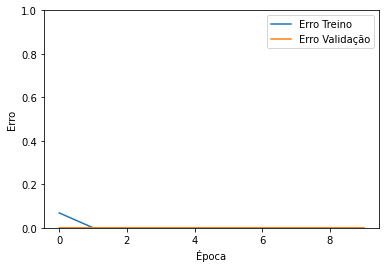

In [19]:
# Mostra o erro de treino e validação a cada época treinada

historico = np.array(historico)

plt.plot(historico[:,0:2])
plt.legend(['Erro Treino', 'Erro Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.ylim(0,1)
plt.show()

In [20]:
# transformacao = transformacoes_de_imagens['teste']
# classe = 'low_temp'
# pasta = f'../data/teste/{classe}/'
# imagem = os.path.join(pasta, os.listdir(pasta)[2])
# imagem_teste = PIL.Image.open(imagem)
# plt.imshow(imagem_teste)

# tensor_imagem_teste = transformacao(imagem_teste)

# tensor_imagem_teste = tensor_imagem_teste.view(1,3, image_size, image_size)
# print(tensor_imagem_teste)

# alexnet.eval()
# saida = alexnet(tensor_imagem_teste)
# saida

In [57]:
def predicao(modelo, tensor_imagem_teste):
    '''
    Função para realizar a predição do status do AR
    Parâmetros
        :param modelo: modelo para testar
        :param arquivo_imagem_teste: caminho para imagem de teste
    '''
    
    # transformacao = transformacoes_de_imagens['teste']

    # imagem_teste = PIL.Image.open(arquivo_imagem_teste)
    # plt.imshow(imagem_teste)
    
    # tensor_imagem_teste = transformacao(imagem_teste)

    # Testa se voce é rico, ops, se tem uma placa NVIDIA :)
    # if torch.cuda.is_available():
    #     tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size).cuda()
    # else:
    #     tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size)
    
    dict_predicoes = dict()
    
    # Não precisa atualizar os coeficientes do modelo
    with torch.no_grad():
        modelo.eval()
        # Modelo retorna as probabilidades em log (log softmax)
        saida = modelo(tensor_imagem_teste)
        
        # torch.exp para voltar a probabilidade de log para a probabilidade linear
        ps = torch.exp(saida)
        
        # topk retorna o os k maiores valores do tensor
        # o tensor de probabilidades vai trazer na 1a posição a classe com maior
        # probabilidade de predição
        topk, topclass = ps.topk(numero_de_classes, dim=1)
        for i in range(numero_de_classes):
            dict_predicoes[indice_para_classe[topclass.cpu().numpy()[0][i]]] = topk.cpu().numpy()[0][i]
    
    return dict_predicoes

In [62]:
listimg[0][0].view(1, 3, image_size, image_size).shape

torch.Size([1, 3, 100, 100])

In [63]:
imagem = listimg[0][0].view(1, 3, image_size, image_size)
predicao(modelo_treinado, imagem)

{'high_temp': 0.99998736, 'low_temp': 1.2649171e-05}

In [69]:
listimg[0][0]

tensor([[[0.5529, 0.5333, 0.5020,  ..., 0.4863, 0.5569, 0.5725],
         [0.4824, 0.4784, 0.4941,  ..., 0.5882, 0.5765, 0.5020],
         [0.5216, 0.5137, 0.5020,  ..., 0.5333, 0.5647, 0.5922],
         ...,
         [0.5294, 0.6471, 0.6902,  ..., 0.4745, 0.5059, 0.5569],
         [0.5647, 0.5804, 0.5647,  ..., 0.4745, 0.4980, 0.5412],
         [0.5529, 0.5569, 0.5333,  ..., 0.4902, 0.5137, 0.4980]],

        [[0.5529, 0.5333, 0.5020,  ..., 0.4863, 0.5569, 0.5725],
         [0.4824, 0.4784, 0.4941,  ..., 0.5882, 0.5765, 0.5020],
         [0.5216, 0.5137, 0.5020,  ..., 0.5333, 0.5647, 0.5922],
         ...,
         [0.5294, 0.6471, 0.6902,  ..., 0.4745, 0.5059, 0.5569],
         [0.5647, 0.5804, 0.5647,  ..., 0.4745, 0.4980, 0.5412],
         [0.5529, 0.5569, 0.5333,  ..., 0.4902, 0.5137, 0.4980]],

        [[0.5529, 0.5333, 0.5020,  ..., 0.4863, 0.5569, 0.5725],
         [0.4824, 0.4784, 0.4941,  ..., 0.5882, 0.5765, 0.5020],
         [0.5216, 0.5137, 0.5020,  ..., 0.5333, 0.5647, 0.

In [70]:
imagem_teste = PIL.Image.open(listimg[0][0])
imagem_teste

AttributeError: 'Tensor' object has no attribute 'read'

In [64]:
# pasta = f'../data/teste/{classe}/'
# imagem = os.path.join(pasta, os.listdir(pasta)[2])
# transformacao = transformacoes_de_imagens['teste']
imagem_teste = PIL.Image.open(listimg[0][0])
imagem_teste
# tensor_imagem_teste = transformacao(listimg[0][0])
# tensor_imagem_teste

AttributeError: 'Tensor' object has no attribute 'read'

RuntimeError: shape '[1, 3, 100, 100]' is invalid for input of size 10000

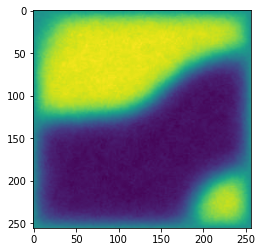

In [23]:
classe = 'low_temp'
pasta = f'../data/teste/{classe}/'
imagem = os.path.join(pasta, os.listdir(pasta)[2])

predicao(modelo_treinado, imagem)

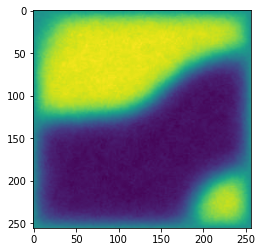

In [35]:
classe = 'low_temp'
pasta = f'../data/teste/{classe}/'
imagem = os.path.join(pasta, os.listdir(pasta)[2])

imagem_teste = PIL.Image.open(imagem)
plt.imshow(imagem_teste)
# img = Image(filename=imagem)
# display(img)

RuntimeError: Given groups=1, weight of size [64, 3, 11, 11], expected input[1, 1, 100, 100] to have 3 channels, but got 1 channels instead

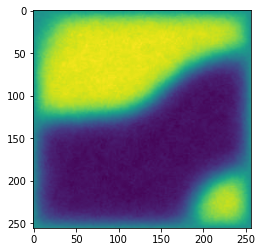

In [36]:
classe = 'low_temp'
pasta = f'../data/teste/{classe}/'
imagem = os.path.join(pasta, os.listdir(pasta)[2])

predicao(modelo_treinado, imagem)

In [28]:
torch.save(modelo_treinado, './modelos/melhor_modelo.pt')